<a href="https://colab.research.google.com/github/Qurazan/Indians-Diabetes-Prediction-Using-Naive-Bayes/blob/main/goal_for92_mycopy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import warnings
warnings.filterwarnings("ignore")
import  numpy as np
import pandas as pd
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler
import xgboost as xgb


uploading dataset

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving diabetes.csv to diabetes.csv


In [ ]:
import io
df = pd.read_csv(io.BytesIO(uploaded['diabetes.csv']))
# Dataset is now stored in a Pandas Dataframe

In [ ]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [ ]:
print(f"Number of Rows {df.shape[0]} and number of colummns {df.shape[1]}")
#Number of Rows 768 and number of colummns 9

Number of Rows 768 and number of colummns 9


Data Imputation

In [ ]:
def cal_median(df,target,var):
    temp = df[df[var].notnull()]
    temp = temp[[var,target]].groupby([target])[[var]].median().reset_index()
    return temp

In [ ]:
def median_imputation(df,target,var,var_0,var_1):
    for i in range(len(df)):
        if df.loc[i,target] == 0 and df.loc[i,var] == 0:
            df.loc[i,var]=var_0
                             
        if df.loc[i,target] == 1 and df.loc[i,var] == 0:
            df.loc[i,var] = var_1

In [ ]:
d = cal_median(df,"Outcome","Insulin")
d

,Outcome,Insulin
0,0,39
1,1,0


In [ ]:
median_imputation(df,"Outcome","Insulin",d.loc[0,"Insulin"],d.loc[1,"Insulin"])
d=cal_median(df,"Outcome","Glucose")
d

,Outcome,Glucose
0,0,107
1,1,140


In [ ]:
median_imputation(df,"Outcome","Glucose",d.loc[0,"Glucose"],d.loc[1,"Glucose"])
d=cal_median(df,"Outcome","SkinThickness")
d

,Outcome,SkinThickness
0,0,21
1,1,27


In [ ]:
median_imputation(df,"Outcome","SkinThickness",d.loc[0,"SkinThickness"],d.loc[1,"SkinThickness"])
d=cal_median(df,"Outcome","BloodPressure")
d

,Outcome,BloodPressure
0,0,70
1,1,74


In [ ]:
median_imputation(df,"Outcome","BloodPressure",d.loc[0,"BloodPressure"],d.loc[1,"BloodPressure"])
d=cal_median(df,"Outcome","BMI")
d

,Outcome,BMI
0,0,30.05
1,1,34.25


In [ ]:
median_imputation(df,"Outcome","BMI",d.loc[0,"BMI"],d.loc[1,"BMI"])


EDA to Open Hidden Pattern of Data

In [ ]:
import plotly.express as exp
import plotly.io as pio

def plot_data(df,varx,vary,target):
    pio.templates.default="simple_white"
    exp.defaults.template = "ggplot2"
    exp.defaults.color_continuous_scale = exp.colors.sequential.Blackbody
    exp.defaults.width = 800
    exp.defaults.height = 600
    fig = exp.scatter(df,x=varx,y=vary,color=target)
    fig.show()


In [ ]:
plot_data(df,"Glucose","Age","Outcome") 

IT shows that age <= 30 and glucose <= 120 people  no symptom of diabetes.
consider it as Rule - N1.

In [ ]:
df.loc[:,"N1"] = 1
df.loc[(df['Age']<=30) & (df['Glucose']<=120),"N1"]=0
df.loc[(df['Age']>30) & (df['Age']<48) & (df['Glucose']<=88),"N1"]=0 # extra
df.loc[(df['Age']>=63) & (df['Glucose']<=142),"N1"]=0 # extra
df.loc[:,'N2']=1
df.loc[(df['BMI']<=30),'N2']=0
plot_data(df,"Pregnancies","Age","Outcome")

In [ ]:
df.loc[:,'N3']=1
df.loc[(df['Age']<=27) & (df['Pregnancies']<=6),'N3']=0
df.loc[(df['Age']>60) & (df['Pregnancies']>7.5),'N3']=0 # extra
plot_data(df,"Glucose","BloodPressure","Outcome")

 blood pressure <=80 and glucose <=105 then person is healthy. cosnider this is as rule - N4.

In [ ]:
df.loc[:,'N4']=1
df.loc[(df['Glucose']<=105) & (df['BloodPressure']<=80),'N4']=0
df.loc[(df['Glucose']<=105) & (df['BloodPressure']>83),'N4']=0 #extra 
df.loc[:,'N5']=1
df.loc[(df['SkinThickness']<=20) ,'N5']=0
plot_data(df,"SkinThickness","BMI","Outcome")

BMI < 30 and Skin Thickness <=20 then person is healthy. consider this is as rule -N6.

In [ ]:
df.loc[:,'N6']=1
df.loc[(df['BMI']<30) & (df['SkinThickness']<=20),'N6']=0
df.loc[(df['BMI']>33) & (df['SkinThickness']<=20),'N6']=0 # extra
plot_data(df,"Glucose","BMI","Outcome")

BMI <= 30 and Glucose <= 105 then person is healthy. Let us consider this is as rule - N7.

In [ ]:
df.loc[:,'N7']=1
df.loc[(df['Glucose']<=105) & (df['BMI']<=30),'N7']=0
df.loc[(df['Glucose']<=105) & (df['BMI'] >=40),'N7']=0 # extra rule included
df.loc[:,'N9']=1
df.loc[(df['Insulin']<200),'N9']=0
df.loc[:,'N10']=1
df.loc[(df['BloodPressure']<80),'N10']=0
df.loc[:,'N11']=1
df.loc[(df['Pregnancies']<4) & (df['Pregnancies']!=0) ,'N11']=0
df['N0'] = df['BMI'] * df['SkinThickness']

df['N8'] =  df['Pregnancies'] / df['Age']

df['N13'] = df['Glucose'] / df['DiabetesPedigreeFunction']

df['N12'] = df['Age'] * df['DiabetesPedigreeFunction']

#df['N14'] = df['Age'] / df['Insulin'] as it is giving inf value
df.loc[:,'N15']=1
df.loc[(df['N0']<1034) ,'N15']=0
#df.drop("N14",axis=1,inplace=True)
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,N1,N2,N3,N4,N5,N6,N7,N9,N10,N11,N0,N8,N13,N12,N15
0,6,148,72,35,0,33.6,0.627,50,1,1,1,1,1,1,1,1,0,0,1,1176.0,0.120000,236.044657,31.350,1
1,1,85,66,29,39,26.6,0.351,31,0,0,0,1,0,1,1,0,0,0,0,771.4,0.032258,242.165242,10.881,0
2,8,183,64,27,0,23.3,0.672,32,1,1,0,1,1,1,1,1,0,0,1,629.1,0.250000,272.321429,21.504,0
3,1,89,66,23,94,28.1,0.167,21,0,0,0,0,0,1,1,0,0,0,0,646.3,0.047619,532.934132,3.507,0
4,0,137,40,35,168,43.1,2.288,33,1,1,1,1,1,1,1,1,0,0,1,1508.5,0.000000,59.877622,75.504,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0,0,1,0,0,1,1,1,0,0,1,1579.2,0.158730,590.643275,10.773,1
764,2,122,70,27,39,36.8,0.340,27,0,1,1,0,1,1,1,1,0,0,0,993.6,0.074074,358.823529,9.180,0
765,5,121,72,23,112,26.2,0.245,30,0,1,0,1,1,1,1,1,0,0,1,602.6,0.166667,493.877551,7.350,0
766,1,126,60,27,0,30.1,0.349,47,1,1,1,1,1,1,1,1,0,0,0,812.7,0.021277,361.031519,16.403,0


In [ ]:
y=pd.DataFrame(df["Outcome"])
x= df.drop("Outcome",axis=1)

In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
for col in y.columns:
    y[col]= encoder.fit_transform(y[col])
y = y["Outcome"]
cols=["N1","N2","N3","N4","N5","N6","N7","N9","N10","N11"]
for col in cols:
    x[col]=encoder.fit_transform(x[col])
  
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=42) #stratify=y)
#Bagging - Decision Tree

Bagging - Decision Tree

In [ ]:
bagging = BaggingClassifier(DecisionTreeClassifier(random_state=42),n_estimators=500,
                           max_samples=100,bootstrap=True,n_jobs=-1,random_state=42,
                           oob_score=True)
bagging.fit(x_train,y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=42),
                  max_samples=100, n_estimators=500, n_jobs=-1, oob_score=True,
                  random_state=42)

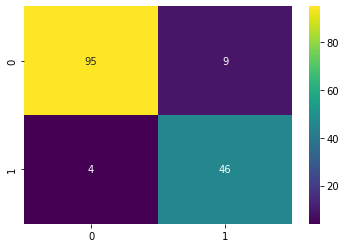

In [ ]:
confusion_matrix = confusion_matrix(bagging.predict(x_test),y_test)
sb.heatmap(confusion_matrix,annot=True,fmt="0.2g",cmap="viridis")
plt.show()

In [ ]:
print(classification_report(bagging.predict(x_test),y_test))

              precision    recall  f1-score   support

           0       0.96      0.91      0.94       104
           1       0.84      0.92      0.88        50

    accuracy                           0.92       154
   macro avg       0.90      0.92      0.91       154
weighted avg       0.92      0.92      0.92       154



Support Vector Machine with GridSearchCV

In [ ]:
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  
std = StandardScaler()
x1 = std.fit_transform(x)
x_train, x_test, y_train, y_test = train_test_split(x1, y, test_size=.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) 
  
# fitting the model for grid search 
grid.fit(x_train, y_train) 

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.659 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.650 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.650 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.650 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.656 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.659 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.650 total time=   0.0s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.650 total time=   0.0s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.659 total time=   0.0s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.664 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.691 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [ ]:
print(classification_report(y_test,grid.predict(x_test)))

              precision    recall  f1-score   support

           0       0.81      0.80      0.80        99
           1       0.64      0.65      0.65        55

    accuracy                           0.75       154
   macro avg       0.72      0.73      0.73       154
weighted avg       0.75      0.75      0.75       154



RandomForest Classifier with GridSearchCV

In [ ]:
rf = RandomForestClassifier(n_jobs=-1,max_features= 'sqrt' ,n_estimators=100, oob_score = True)
param_grid = { 
    'n_estimators': [200, 700],
    'max_features': ['auto', 'sqrt', 'log2']
}

rfc = GridSearchCV(estimator=rf, param_grid=param_grid, cv= 5)
rfc.fit(x_train,y_train)
print(classification_report(y_test,rfc.predict(x_test)))

              precision    recall  f1-score   support

           0       0.91      0.90      0.90        99
           1       0.82      0.84      0.83        55

    accuracy                           0.88       154
   macro avg       0.86      0.87      0.87       154
weighted avg       0.88      0.88      0.88       154

